<div class="alert alert-info" markdown="1">

#### Lecture 13


# Text Analysis II - Topic Modeling
    
</div>

This notebook analyzes the **State of the Union** corpus, 1970-2025. Source: [The American Presidency Project](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union)
- Tasks covered:
  - Loading and lightly cleaning a raw corpus
  - Building a **Document–Term Matrix** (DTM) with `CountVectorizer`
  - Measure document similarity with cosine similarity
  - Building a **TF–IDF** representation with `TfidfVectorizer`
  - Fitting **Latent Dirichlet Allocation (LDA)** (scikit-learn + optional gensim)
  - Fitting **BERTopic** (Transformer-based topic modeling)
  - Interpreting topics (top terms) and document-topic weights
  - Optional visualizations with `pyLDAvis` and BERTopic's `.visualize_topics()`

In [1]:
# If you're in a managed environment, you may not need these installs.
# Uncomment if needed.
## ! conda activate qss20
## ! conda install pyLDAvis gensim bertopic sentence-transformers umap-learn hdbscan wordcloud

import re
import io
import sys
import json
import math
import textwrap
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import normalize
import gensim
from gensim import corpora, models
from wordcloud import WordCloud
import pyLDAvis
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from bertopic import BERTopic
# pd.set_option("display.max_colwidth", 120)

## Load & Quick Peek

In [2]:
with open('../../public_data/stateoftheunion1790-2025.txt') as f:
    text = f.read()
    
print(f"Characters: {len(text):,}")
print("\n--- BEGIN PREVIEW ---")
print(text[:1000])
print("\n--- END PREVIEW ---")

Characters: 10,675,837

--- BEGIN PREVIEW ---
The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2023 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Add

### Terminology

- In text analysis, each piece of text we want to analyze is called a **document**.<br><small>Here, each speech is a document.</small>

- Documents are made up of **terms**, i.e. words.

- A collection of documents is called a **corpus**.<br><small>Here, the corpus is the set of all SOTU speeches from 1790-2025.</small>

### Extracting speeches

- In the string `sotu`, each document is separated by `'***'`.

In [3]:
speeches_lst = text.split('\n***\n')[1:]
len(speeches_lst)

235

- Note that each "speech" currently contains other information, like the name of the president and the date of the address.

- Let's extract just the text of each speech and put it in a DataFrame.<br><small>Along the way, we'll use our new knowledge of regular expressions to remove capitalization and punctuation, so we can just focus on the content itself.</small>

In [4]:
def create_speeches_df(speeches_lst):
    def extract_struct(speech):
        L = speech.strip().split('\n', maxsplit=3)
        L[3] = re.sub(r'\n', '', L[3])
        # L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower() # Replaces anything OTHER than letters with ' '.
        # L[3] = re.sub(r"it's", 'it is', L[3]).replace(' s ', '')
        return dict(zip(['president', 'date', 'text'], L[1:]))
    speeches = pd.DataFrame(list(map(extract_struct, speeches_lst)))
    # speeches.index = speeches['president'].str.strip() + ': ' + speeches['date']
    # speeches = speeches[['text']]
    return speeches

In [5]:
docs_df = create_speeches_df(speeches_lst)
docs_df['date'] = pd.to_datetime(docs_df['date'], errors='coerce')
docs_df['year'] = docs_df['date'].dt.year
docs_df

,president,date,text,year
0,George Washington,1790-01-08,Fellow-Citizens of the Senate and House of Rep...,1790
1,George Washington,1790-12-08,Fellow-Citizens of the Senate and House of Rep...,1790
2,George Washington,1791-10-25,Fellow-Citizens of the Senate and House of Rep...,1791
3,George Washington,1792-11-06,Fellow-Citizens of the Senate and House of Rep...,1792
4,George Washington,1793-12-03,Fellow-Citizens of the Senate and House of Rep...,1793
...,...,...,...,...
230,Joseph R. Biden Jr.,2021-04-28,Thank you. Thank you. Thank you. Good to be ba...,2021
231,Joseph R. Biden Jr.,2022-03-01,"Madam Speaker, Madam Vice President, and our F...",2022
232,Joseph R. Biden Jr.,2023-02-07,Mr. Speaker. Madam Vice President. Our First...,2023
233,Joseph R. Biden Jr.,2024-03-07,Good evening. Mr. Speaker. Madam Vice Presiden...,2024


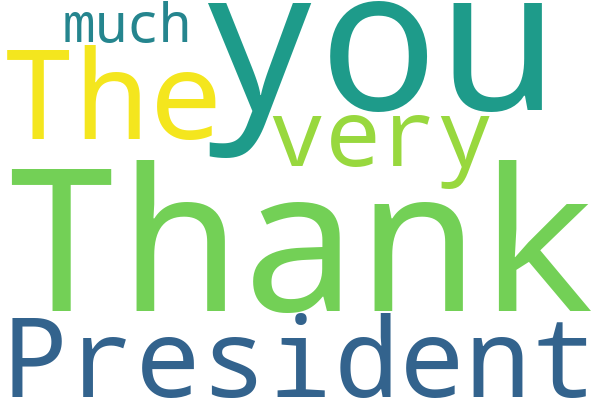

In [56]:
# Create a WordCloud object
wordcloud = WordCloud(width=600,
                      height=400,
                      background_color="white", 
                      stopwords="english",
                      max_words=100,
                      colormap="viridis")
# Generate a word cloud
wordcloud.generate(docs_df['text'][-1:].to_string(index=False, header=False))
# Visualize the word cloud
wordcloud.to_image()

## Cleaning
We'll do light normalization suitable for classic NLP steps.

In [7]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def basic_clean(s: str) -> str:
    # Normalize newlines and spaces
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    # Remove non-printable chars
    s = ''.join(ch for ch in s if ch.isprintable() or ch in ["\n", "\t"])
    # Remove words only containing digits
    s = re.sub(r"\b\d+\b", " ", s)
    # Remove words started with digits
    s = re.sub(r"\b\d\w*\b", " ", s)
    # Lowercase and tokenize
    tokens = re.findall(r"\b[a-zA-Z]+\b", s.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # stem
    # tokens = [stemmer.stem(word) for word in tokens]
    # Rejoin into a cleaned string
    return " ".join(tokens)

docs_df["text_clean"] = docs_df["text"].map(basic_clean)
docs_df.head(2)

,president,date,text,year,text_clean
0,George Washington,1790-01-08,Fellow-Citizens of the Senate and House of Rep...,1790,fellow citizens senate house representatives e...
1,George Washington,1790-12-08,Fellow-Citizens of the Senate and House of Rep...,1790,fellow citizens senate house representatives m...


## Document–Term Matrix (DTM)

- Rows: documents (speeches)  
- Columns: terms (vocabulary)  
- Values: term counts per document

We'll limit the vocabulary (e.g., `min_df`, `max_df`) to reduce noise.


In [61]:
vectorizer = CountVectorizer(stop_words="english", min_df=5, max_df=0.7)
X_counts = vectorizer.fit_transform(docs_df["text_clean"])
vocab = vectorizer.get_feature_names_out()

dtm = pd.DataFrame(X_counts.toarray(), columns=vocab)
print("DTM shape:", dtm.shape)
dtm

DTM shape: (235, 12253)


,abalance,abalanced,abandon,abandoned,abandoning,abandonment,abdication,abetter,abeyance,abide,...,youthful,youths,youwill,yukon,zeal,zealand,zealous,zero,zone,zones
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,0
231,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We can print out the most highly counted words that appeared in the last SOTU

In [66]:
count_values = X_counts[-1].toarray().flatten()
count_dict = {vocab[i]: count_values[i] for i in np.where(count_values > 0)[0]}
# sort by value (frequency) in descending order
sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
sorted_count_dict

{'thank': 72,
 'going': 53,
 'members': 28,
 'want': 28,
 'laughter': 27,
 'million': 26,
 'audience': 25,
 'administration': 21,
 'job': 19,
 'money': 18,
 'beautiful': 17,
 'tonight': 17,
 'border': 16,
 'dollars': 16,
 'history': 16,
 'know': 16,
 'ago': 15,
 'tax': 15,
 'biden': 14,
 'love': 13,
 'member': 13,
 'office': 12,
 'seen': 12,
 'americans': 11,
 'billion': 11,
 'fight': 11,
 'hard': 11,
 'old': 11,
 'speaker': 11,
 'tariffs': 11,
 'working': 11,
 'big': 10,
 'children': 10,
 'federal': 10,
 'let': 10,
 'really': 10,
 'dangerous': 9,
 'everybody': 9,
 'got': 9,
 'lot': 9,
 'policies': 9,
 'signed': 9,
 'actually': 8,
 'daughter': 8,
 'getting': 8,
 'green': 8,
 'hundreds': 8,
 'illegal': 8,
 'johnson': 8,
 'mr': 8,
 'person': 8,
 'police': 8,
 'social': 8,
 'spoke': 8,
 'ukraine': 8,
 'young': 8,
 'allowed': 7,
 'bad': 7,
 'billions': 7,
 'heard': 7,
 'inflation': 7,
 'january': 7,
 'killed': 7,
 'percent': 7,
 'point': 7,
 'said': 7,
 'stop': 7,
 'taking': 7,
 'tariff': 

## Cosing Similarity: Measure Similar Speeches

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

sim_dtm = cosine_similarity(dtm)
print("Similarity matrix shape:", sim_dtm.shape[0])

Similarity matrix shape: 235


In [ ]:
# extract upper-triangle pairs (i < j), excluding diagonal
i_upper, j_upper = np.triu_indices(sim_dtm.shape[0], k=1)
sim_dtm_upper = sim_dtm[i_upper, j_upper]

pairs = pd.DataFrame({
    "i": i_upper,
    "j": j_upper,
    "cosine_sim": sim_dtm_upper,
    "president_i": docs_df.loc[i_upper, "president"].values,
    "year_i": docs_df.loc[i_upper, "year"].values,
    "president_j": docs_df.loc[j_upper, "president"].values,
    "year_j": docs_df.loc[j_upper, "year"].values,
})
pairs["speech_i"] = pairs["president_i"].astype(str) + "-" + pairs["year_i"].astype(str)
pairs["speech_j"] = pairs["president_j"].astype(str) + "-" + pairs["year_j"].astype(str)

# top 10 most similar / least similar ----
top10 = pairs.sort_values("cosine_sim", ascending=False).head(10).reset_index(drop=True)
bottom10 = pairs.sort_values("cosine_sim", ascending=True).head(10).reset_index(drop=True)

print("\nTop 10 most similar pairs:")
display(top10[["speech_i", "speech_j", "cosine_sim"]])

print("\nTop 10 least similar pairs:")
display(bottom10[["speech_i", "speech_j", "cosine_sim"]])


Top 10 most similar pairs:


,speech_i,speech_j,cosine_sim
0,William J. Clinton-1998,William J. Clinton-1999,0.737225
1,Barack Obama-2013,Barack Obama-2014,0.727637
2,William J. Clinton-1998,William J. Clinton-2000,0.724267
3,James Polk-1846,James Polk-1847,0.723928
4,William J. Clinton-1997,William J. Clinton-1998,0.719463
5,William J. Clinton-1999,William J. Clinton-2000,0.714728
6,Theodore Roosevelt-1905,Theodore Roosevelt-1907,0.711513
7,William H. Taft-1909,William H. Taft-1912,0.701247
8,Dwight D. Eisenhower-1955,Dwight D. Eisenhower-1956,0.698868
9,Barack Obama-2014,Barack Obama-2015,0.697081



Top 10 least similar pairs:


,speech_i,speech_j,cosine_sim
0,John Adams-1800,George W. Bush-2001,0.032645
1,John Adams-1800,Richard Nixon-1973,0.033491
2,John Adams-1800,Donald J. Trump -2017,0.034327
3,James Madison-1814,Richard Nixon-1973,0.034421
4,John Adams-1799,Gerald R. Ford-1975,0.034765
5,John Adams-1800,Joseph R. Biden Jr. -2024,0.035388
6,John Adams-1800,Barack Obama-2012,0.036310
7,John Adams-1800,Barack Obama-2009,0.036417
8,John Adams-1800,Joseph R. Biden Jr. -2022,0.037694
9,John Adams-1800,Barack Obama-2014,0.038070


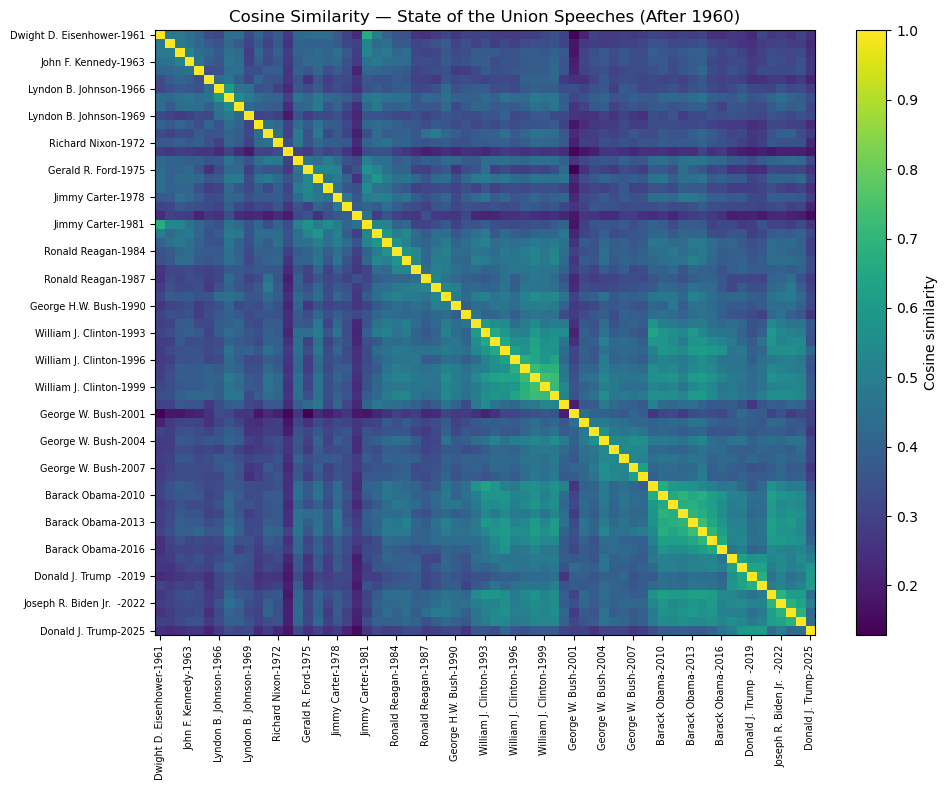

In [15]:
# boolean mask for speeches after 1960
mask = docs_df["year"] > 1960
# get index positions
idx = np.where(mask)[0]
# subset the similarity matrix
sim_dtm_post1960 = sim_dtm[np.ix_(idx, idx)]
# subset metadata for labeling
docs_post1960 = docs_df.iloc[idx].reset_index(drop=True)
labels = docs_post1960["president"].astype(str) + "-" + docs_post1960["year"].astype(str)

plt.figure(figsize=(10, 8))
plt.imshow(sim_dtm_post1960, aspect="auto")
plt.colorbar(label="Cosine similarity")
plt.title("Cosine Similarity — State of the Union Speeches (After 1960)")
N = len(labels)
k = max(1, N // 20)
tick_idx = np.arange(0, N, k)

plt.xticks(tick_idx, labels.iloc[tick_idx], rotation=90, fontsize=7)
plt.yticks(tick_idx, labels.iloc[tick_idx], fontsize=7)

plt.tight_layout()
plt.show()

## TF–IDF Representation

TF–IDF down-weights ubiquitous words and up-weights discriminative ones.

In [48]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=5, max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(docs_df["text_clean"])
tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

print("TF–IDF shape:", X_tfidf.shape)
dtm_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vocab)
print("DTM shape:", dtm_tfidf.shape)
dtm_tfidf

TF–IDF shape: (235, 12253)
DTM shape: (235, 12253)


,abalance,abalanced,abandon,abandoned,abandoning,abandonment,abdication,abetter,abeyance,abide,...,youthful,youths,youwill,yukon,zeal,zealand,zealous,zero,zone,zones
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.065,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.046056,0.000000,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.034972,0.000000,0.049791,0.000000,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.014242,0.025464,0.0
231,0.0,0.0,0.008877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.014697,0.000000,0.014128,0.000000,0.0
232,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.016433,0.000000,0.0
233,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.016787,0.000000,0.0


Word cloud based on TF–IDF weights

In [65]:
tfidf_weights = X_tfidf[-1].toarray().flatten()
# Build a dictionary {word: weight}
tfidf_dict = {tfidf_vocab[i]: tfidf_weights[i] for i in np.where(tfidf_weights > 0)[0]}
sorted_tfidf_dict = dict(sorted(tfidf_dict.items(), key=lambda item: item[1], reverse=True))
sorted_tfidf_dict

{'thank': 0.45647497678620397,
 'audience': 0.2752901216574551,
 'going': 0.27172606407964556,
 'laughter': 0.2382704113114186,
 'biden': 0.1503555470149174,
 'beautiful': 0.15002211082570802,
 'million': 0.12018149675315949,
 'want': 0.10647469893593753,
 'tonight': 0.10544862173939604,
 'job': 0.10087408552318856,
 'members': 0.1008039740396047,
 'border': 0.09996393788704722,
 'tariffs': 0.09707313053428164,
 'green': 0.09052471077494462,
 'johnson': 0.08591745543709566,
 'everybody': 0.07942347043713954,
 'daughter': 0.07897029743463024,
 'ukraine': 0.07897029743463024,
 'member': 0.07786275427928104,
 'love': 0.07630194025499659,
 'administration': 0.07359539925020711,
 'dollars': 0.06956850258114892,
 'gang': 0.06789353308120846,
 'got': 0.06690369873966362,
 'big': 0.06435529341689171,
 'money': 0.0636483126269443,
 'spoke': 0.061266482404485526,
 'know': 0.06028464832321606,
 'lot': 0.06022144038797297,
 'fight': 0.058749130471807916,
 'joe': 0.058301087301371735,
 'mandate': 0

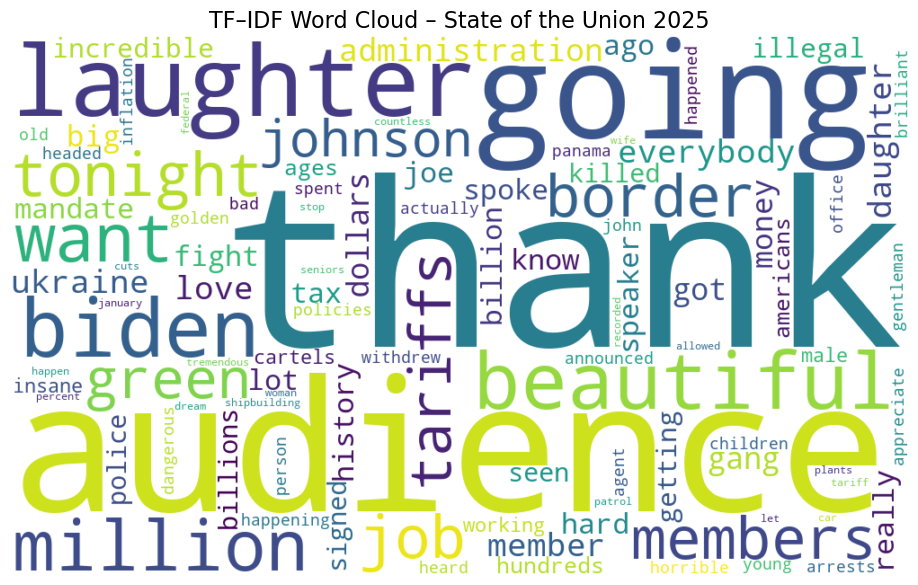

In [50]:
# Generate the word cloud using TF–IDF weights as frequencies
wc_tfidf = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    colormap="viridis",
    max_words=100
).generate_from_frequencies(tfidf_dict)

# Plot
plt.figure(figsize=(12, 7))
plt.imshow(wc_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title(f"TF–IDF Word Cloud – State of the Union 2025", fontsize=16)
plt.show()


## Latent Dirichlet Allocation (LDA) — scikit-learn

We fit LDA on **count data** (DTM). Tune `n_components` to explore different granularities of topics.


In [75]:
n_topics = 20  # adjust as desired
lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method="batch",
    random_state=42,
    max_iter=20
)

lda.fit(X_counts)

terms = vectorizer.get_feature_names_out()

def show_top_words(model, feature_names, n_top_words=12):
    topic_terms = []
    for topic_idx, comp in enumerate(model.components_):
        top_ids = comp.argsort()[-n_top_words:][::-1]
        words = [feature_names[i] for i in top_ids]
        topic_terms.append(words)
        print(f"Topic {topic_idx:02d}: " + ", ".join(words))
    return topic_terms

topic_terms = show_top_words(lda, terms, n_top_words=12)

Topic 00: man, matter, conditions, labor, navy, individual, question, kind, corporations, merely, ships, true
Topic 01: retains, angry, provocations, theproduction, commonsense, scholars, distressed, afree, verify, thedetermination, enthusiastic, riches
Topic 02: mexico, constitution, treasury, treaty, territory, subject, condition, duties, texas, period, republic, secretary
Topic 03: thank, audience, beautiful, laughter, tariffs, member, agent, biden, gang, green, johnson, april
Topic 04: problems, soviet, conditions, rulers, atomic, economic, executive, communist, labor, republic, capital, know
Topic 05: economic, program, federal, labor, production, farm, strength, income, responsibility, recommend, problems, cooperation
Topic 06: americans, let, tonight, know, jobs, help, children, tax, want, care, health, families
Topic 07: dollars, fiscal, million, expenditures, program, billion, estimated, federal, veterans, total, production, employment
Topic 08: tonight, vietnam, billion, help


### Document–Topic Mixtures

Each document has a probability distribution over topics. Let's inspect a sample.


In [76]:
doc_topic = lda.transform(X_counts)  # shape: (n_docs, n_topics)
doc_topic_df = pd.DataFrame(doc_topic, columns=[f"topic_{i:02d}" for i in range(n_topics)])
doc_topic_df["year"] = docs_df["year"]
doc_topic_df["president"] = docs_df["president"]
doc_topic_df.head()

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,...,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year,president
0,0.000161,0.000161,0.244021,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,...,0.000161,0.000161,0.000161,0.000161,0.000161,0.686965,0.000161,0.000161,1790,George Washington
1,0.000127,0.000127,0.000127,0.000127,0.000127,0.000127,0.000127,0.084804,0.000127,0.000127,...,0.000127,0.000127,0.000127,0.000127,0.000127,0.912906,0.000127,0.000127,1790,George Washington
2,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.998545,0.000077,0.000077,1791,George Washington
3,0.000082,0.000082,0.044575,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,...,0.081501,0.000082,0.000082,0.000082,0.000082,0.825266,0.000082,0.000082,1792,George Washington
4,0.000092,0.000092,0.226800,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,...,0.137826,0.000092,0.000092,0.000092,0.000092,0.633815,0.000092,0.000092,1793,George Washington



### Topic Prevalence over Time

We can look at which topics are most prominent in different periods by averaging topic weights by decade.


In [77]:
def decade(y):
    try:
        return int(y) - (int(y) % 10)
    except:
        return None

doc_topic_df["decade"] = docs_df["year"].map(decade)
topic_by_decade = doc_topic_df.groupby("decade").mean(numeric_only=True)
topic_by_decade

,topic_00,topic_01,topic_02,topic_03,topic_04,topic_05,topic_06,topic_07,topic_08,topic_09,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,year
decade,,,,,,,,,,,,,,,,,,,,,
1790,0.002969,0.000092,0.157833,0.000092,0.000092,0.000092,0.000892,0.007790,0.001540,0.000092,...,0.001876,0.038327,0.000092,0.000092,0.000092,0.001243,0.751478,0.000092,0.000092,1794.090909
1800,0.001690,0.000078,0.224116,0.000078,0.000078,0.000078,0.001930,0.008338,0.000078,0.000078,...,0.001744,0.011993,0.000078,0.000078,0.000078,0.000078,0.749171,0.000078,0.000078,1804.500000
1810,0.005384,0.000055,0.227054,0.000055,0.000055,0.000055,0.000055,0.007026,0.000055,0.000055,...,0.011286,0.004046,0.000055,0.000055,0.000055,0.004277,0.720881,0.000055,0.000055,1814.500000
1820,0.003815,0.000028,0.147572,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,...,0.000028,0.026277,0.000028,0.000028,0.000028,0.005644,0.785316,0.000028,0.000028,1824.500000
1830,0.003921,0.000017,0.288675,0.000017,0.000017,0.000967,0.000527,0.000017,0.000017,0.000017,...,0.000017,0.031697,0.000017,0.000017,0.000017,0.051344,0.569177,0.000017,0.000017,1834.500000
1840,0.000016,0.000016,0.660038,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,0.000016,...,0.000016,0.010479,0.000016,0.000016,0.000016,0.090170,0.225632,0.000016,0.000016,1844.500000
1850,0.000041,0.000015,0.618264,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015,...,0.000015,0.000015,0.000015,0.000015,0.000015,0.137639,0.193489,0.000015,0.000015,1854.500000
1860,0.006808,0.000021,0.329676,0.000021,0.000021,0.000021,0.003671,0.000021,0.000021,0.000021,...,0.000021,0.007660,0.000021,0.000021,0.000021,0.222414,0.110077,0.000021,0.000021,1864.500000
1870,0.002866,0.000022,0.111850,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.001723,0.000022,0.000022,0.000022,0.532931,0.122386,0.099938,0.000022,1874.500000


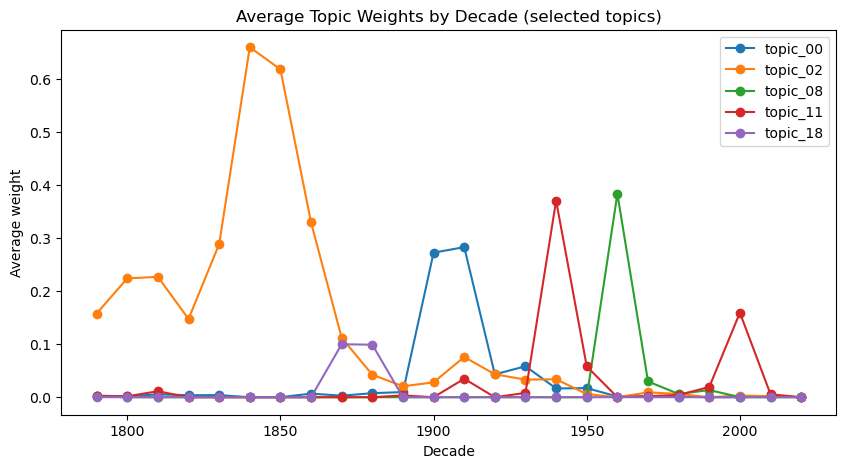

In [78]:
# Simple plot for a few topics to illustrate (adjust indices as needed)
select_topics = [0, 2, 8, 11, 18]
ax = topic_by_decade[ [f"topic_{i:02d}" for i in select_topics] ].plot(kind="line", figsize=(10,5), marker="o")
ax.set_title("Average Topic Weights by Decade (selected topics)")
ax.set_ylabel("Average weight")
ax.set_xlabel("Decade")
plt.show()

## Gensim LDA + pyLDAvis

In [82]:
tokenized = [t.split() for t in docs_df["text_clean"].tolist()]
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.7)
dictionary.compactify()
corpus = [dictionary.doc2bow(toks) for toks in tokenized]
len(dictionary), len(corpus)

(12402, 235)

In [83]:
num_topics = 12
lda_gensim = models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=0,
    chunksize=2000,
    passes=5,
    iterations=200,
    alpha='auto',
    eta='auto',
    eval_every=None
)

for t in lda_gensim.print_topics(num_topics=num_topics, num_words=12):
    print(t)

(0, '0.002*"subject" + 0.002*"let" + 0.002*"tonight" + 0.002*"americans" + 0.001*"want" + 0.001*"department" + 0.001*"know" + 0.001*"jobs" + 0.001*"commerce" + 0.001*"mexico" + 0.001*"officers" + 0.001*"tax"')
(1, '0.008*"americans" + 0.006*"tonight" + 0.006*"let" + 0.006*"jobs" + 0.006*"know" + 0.005*"get" + 0.004*"tax" + 0.004*"want" + 0.004*"help" + 0.004*"care" + 0.004*"thank" + 0.004*"children"')
(2, '0.002*"tonight" + 0.002*"thank" + 0.002*"americans" + 0.002*"federal" + 0.002*"department" + 0.001*"subject" + 0.001*"know" + 0.001*"help" + 0.001*"relations" + 0.001*"members" + 0.001*"program" + 0.001*"strength"')
(3, '0.005*"man" + 0.003*"conditions" + 0.003*"labor" + 0.003*"army" + 0.003*"navy" + 0.002*"matter" + 0.002*"commerce" + 0.002*"officers" + 0.002*"corporations" + 0.002*"question" + 0.002*"interstate" + 0.002*"control"')
(4, '0.003*"treaty" + 0.003*"constitution" + 0.003*"subject" + 0.003*"mexico" + 0.003*"department" + 0.003*"secretary" + 0.003*"treasury" + 0.002*"terri

In [84]:
vis = pyLDAvis.gensim_models.prepare(lda_gensim, corpus, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.029079 -0.021577       1        1   0.001245
1     -0.220006 -0.032793       2        1  13.163434
2     -0.037167 -0.015902       3        1   0.002163
3      0.017037  0.067187       4        1   8.394628
4      0.092218 -0.005529       5        1  23.996429
5      0.032856  0.071073       6        1   9.071421
6      0.051273 -0.008313       7        1   5.721333
7      0.018728 -0.030385       8        1   0.333336
8      0.116063 -0.056157       9        1   5.573506
9      0.092510  0.007405      10        1  13.362534
10    -0.117725  0.041158      11        1  20.377022
11    -0.016709 -0.016166      12        1   0.002949, topic_info=                Term         Freq        Total Category  logprob  loglift
3367       americans   918.000000   918.000000  Default  30.0000  30.0000
12141        tonight   654.000000   654.000000  Default  29.0000  29.0000
522          subject  1163.000000  1163.000000  Default  28.0000  28.0000
424              let   873.000000   873.000000  Default  27.0000  27.0000
374          federal  1067.000000  1067.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
892              tax     0.014589   796.368324  Topic12  -7.0161  -0.4760
3076     governments     0.013996   663.026333  Topic12  -7.0576  -0.3342
2927           labor     0.013975   692.653132  Topic12  -7.0591  -0.3794
1212          treaty     0.013806  1024.073458  Topic12  -7.0713  -0.7826
50     consideration     0.013518   764.691535  Topic12  -7.0924  -0.5117

[986 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
11125      2  0.145753             aboard
11125      4  0.728766             aboard
11775     11  0.787859       acceleration
7436       4  0.717638          accidents
7436       6  0.047843          accidents
...      ...       ...                ...
11253      7  0.044762         wrongdoing
11253     11  0.089525         wrongdoing
940        7  0.609013  yourdeliberations
940       10  0.406009  yourdeliberations
5709       5  0.752206             youths

[3660 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])


## BERTopic — Transformer-based Topic Modeling

**Pipeline:** Text → Sentence Embeddings → UMAP (dim. reduction) → HDBSCAN (clustering) → Topic representation.

Notes:
- Works well on short texts but also produces coherent topics on longer documents.
- Slower than LDA; you can subsample if needed for demos.


In [108]:
from hdbscan import HDBSCAN
from umap import UMAP

hdbscan_model = HDBSCAN(min_cluster_size=12, prediction_data=True)
umap_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine')
texts = docs_df["text_clean"].tolist()
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")
topic_model = BERTopic(verbose=True, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(texts)
info = topic_model.get_topic_info()
info

2025-10-21 02:51:23,161 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2025-10-21 02:51:26,296 - BERTopic - Embedding - Completed ✓
2025-10-21 02:51:26,296 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-21 02:51:26,571 - BERTopic - Dimensionality - Completed ✓
2025-10-21 02:51:26,571 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-21 02:51:26,577 - BERTopic - Cluster - Completed ✓
2025-10-21 02:51:26,579 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-21 02:51:31,682 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13,-1_government_world_congress_people,"[government, world, congress, people, states, ...",[congress united states honor report congress ...
1,0,119,0_states_government_united_united states,"[states, government, united, united states, co...",[fellow citizens senate house representatives ...
2,1,75,1_america_people_world_new,"[america, people, world, new, american, year, ...",[mr speaker mr vice president members congress...
3,2,28,2_government_war_year_congress,"[government, war, year, congress, people, worl...",[congress united states assembling clouded sen...


In [103]:
# Inspect one topic
if len(info) > 1:
    first_topic_id = int(info.iloc[1]["Topic"])
    display(topic_model.get_topic(first_topic_id))

[('states', 0.015104924817491898),
 ('government', 0.013056267570973707),
 ('united', 0.010864886722532403),
 ('united states', 0.010257909831200432),
 ('congress', 0.009548340794488542),
 ('public', 0.00762978589070283),
 ('country', 0.0073718677632553615),
 ('great', 0.006885917164489338),
 ('year', 0.006526188263604563),
 ('people', 0.005984659232936917)]